# **Fairness Analysis on Bank Marketing Dataset**

## **1. Context**
The dataset originates from a Portuguese bank's marketing campaign that aimed to predict whether a client would subscribe to a term deposit. It was collected from phone calls made to clients, recording various attributes such as age, job, education, and response to previous campaigns.

- **Goal:** Predict the likelihood of a client subscribing to a term deposit.
- **Source:** UCI Machine Learning Repository.
- **Size:** 41,188 instances with 20 features and 1 target variable (`y`).

## **2. Exploratory Data Analysis**
We analyze the distribution of the target variable, and explore subscription rates across age groups and job types.


In [5]:
# Load Data and Inspect
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Load dataset
df = pd.read_csv("data/bank-additional-full.csv", sep=";")

# Display dataset structure
print("\n🟢 Dataset Information:\n")
df.info()

# Show first few rows
print("\n🟢 First 5 Rows:\n")
print(df.head())

# Dataset shape
print("\n🟢 Dataset Shape:", df.shape)

# Check for missing values
print("\n🟢 Missing Values in Each Column:\n")
print(df.isnull().sum())

# Display basic statistics (only for numeric columns)
print("\n🟢 Summary Statistics:\n")
print(df.describe())



🟢 Dataset Information:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.c

## **2.1 Target Variable Distribution**
We examine the proportion of clients who subscribed (`yes`) versus those who didn't (`no`).


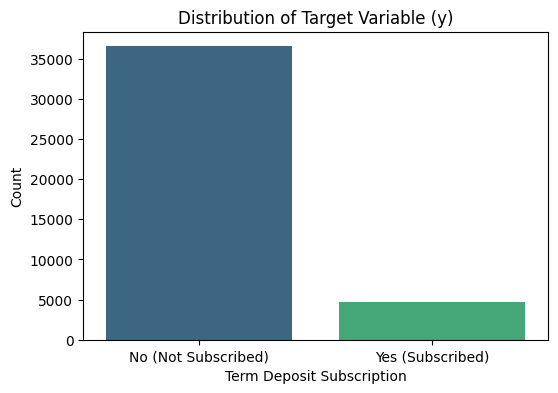


🔹 Subscription Rate: 11.27% (Proportion of 'Yes')



In [6]:
# Convert target variable to binary (0 = No, 1 = Yes)
df['y'] = df['y'].apply(lambda x: 1 if x == 'yes' else 0)

# Plot target variable distribution
plt.figure(figsize=(6,4))
sns.countplot(x=df['y'], palette='viridis')
plt.xticks([0,1], ['No (Not Subscribed)', 'Yes (Subscribed)'])
plt.xlabel("Term Deposit Subscription")
plt.ylabel("Count")
plt.title("Distribution of Target Variable (y)")
plt.show()

# Print subscription rates
subscription_rate = df['y'].mean()
print(f"\n🔹 Subscription Rate: {subscription_rate:.2%} (Proportion of 'Yes')\n")


The dataset is highly imbalanced, with only 11.27% of clients subscribing to a term deposit.

## **2.2 Subscription Rate by Age Group and Job Type**
We analyze how subscription rates vary across **age groups** and **job types**, which are relevant for fairness considerations.


In [7]:
# Create Age Groups
df['age_group'] = pd.cut(df['age'], bins=[18, 30, 60, 100], labels=['Young', 'Middle-aged', 'Older'])


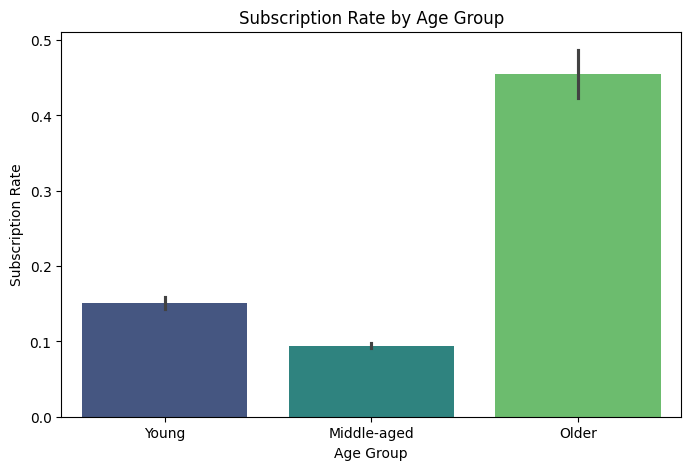

In [8]:
# Subscription Rate by Age Group
plt.figure(figsize=(8,5))
sns.barplot(x=df['age_group'], y=df['y'], palette='viridis')
plt.xlabel("Age Group")
plt.ylabel("Subscription Rate")
plt.title("Subscription Rate by Age Group")
plt.show()


Older clients have a significantly higher subscription rate compared to younger and middle-aged groups.

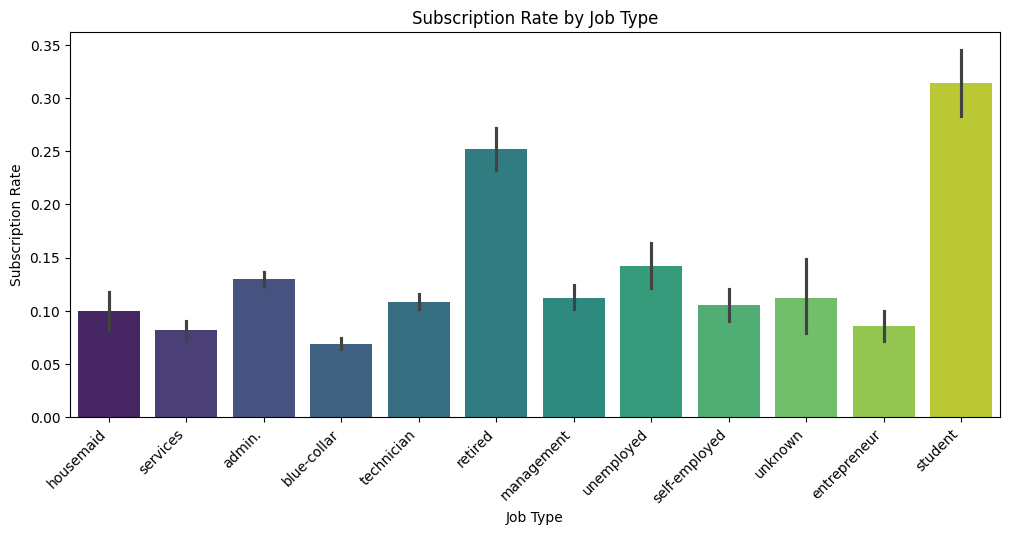

In [9]:
# Subscription Rate by Job Type
plt.figure(figsize=(12,5))
sns.barplot(x=df['job'], y=df['y'], palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.xlabel("Job Type")
plt.ylabel("Subscription Rate")
plt.title("Subscription Rate by Job Type")
plt.show()



Students and retired individuals have the highest subscription rates.

## **3.1 Fairness Analysis (Age as Sensitive Attribute)**
We train a **Logistic Regression Classifier** and compute fairness metrics:
- **Demographic Parity Difference**: Checks if positive predictions are fairly distributed.
- **Equal Opportunity Difference**: Ensures fairness in recall rates.


In [16]:
# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

df_encoded = df.copy()
categorical_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 
                    'contact', 'month', 'day_of_week', 'poutcome']

for col in categorical_cols:
    df_encoded[col] = LabelEncoder().fit_transform(df_encoded[col])

X = df_encoded.drop(columns=['y', 'age_group'])
y = df_encoded['y']
Z = df['age_group'].map({'Young': 0, 'Middle-aged': 1, 'Older': 2})

X_train, X_test, y_train, y_test, Z_train, Z_test = train_test_split(X, y, Z, test_size=0.2, random_state=42, stratify=y)


In [11]:
# Train Model
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

model = LogisticRegression(C=1, max_iter=1000)
# RandomForestClassifier(n_estimators=200, max_depth=8, random_state=0, class_weight='balanced')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(f'Accuracy: {accuracy_score(y_test, y_pred):.4f}')
print(classification_report(y_test, y_pred))


Accuracy: 0.9139
              precision    recall  f1-score   support

           0       0.93      0.98      0.95      7310
           1       0.70      0.42      0.52       928

    accuracy                           0.91      8238
   macro avg       0.81      0.70      0.74      8238
weighted avg       0.90      0.91      0.90      8238



In [12]:
# Compute Fairness Metrics
import numpy as np

def compute_group_rates(y_true, y_pred, group):
    group_idx = (Z_test == group)
    tp = np.sum((y_pred[group_idx] == 1) & (y_true[group_idx] == 1))
    tn = np.sum((y_pred[group_idx] == 0) & (y_true[group_idx] == 0))
    fp = np.sum((y_pred[group_idx] == 1) & (y_true[group_idx] == 0))
    fn = np.sum((y_pred[group_idx] == 0) & (y_true[group_idx] == 1))
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    tnr = tn / (tn + fp) if (tn + fp) > 0 else 0
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
    return tpr, fpr, tnr, fnr

for group in [0, 1, 2]:
    print(f'Age Group {group}:', compute_group_rates(y_test, y_pred, group))


Age Group 0: (0.3251231527093596, 0.028386050283860504, 0.9716139497161395, 0.6748768472906403)
Age Group 1: (0.4283464566929134, 0.019581589958158997, 0.980418410041841, 0.5716535433070866)
Age Group 2: (0.5238095238095238, 0.15, 0.85, 0.47619047619047616)


## **3.2 Fairness Analysis (Job Type as Sensitive Attribute)**
We repeat the analysis by setting job type as the sensitive attribute.


In [13]:
# Preprocessing
df_encoded['job'] = LabelEncoder().fit_transform(df_encoded['job'])
X = df_encoded.drop(columns=['y', 'job', 'age_group'])
y = df_encoded['y']
Z = df_encoded['job']

X_train, X_test, y_train, y_test, Z_train, Z_test = train_test_split(X, y, Z, test_size=0.2, random_state=42, stratify=y)


In [14]:
# Train Model
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(f'Accuracy: {accuracy_score(y_test, y_pred):.4f}')
print(classification_report(y_test, y_pred))


Accuracy: 0.9136
              precision    recall  f1-score   support

           0       0.93      0.98      0.95      7310
           1       0.70      0.41      0.52       928

    accuracy                           0.91      8238
   macro avg       0.81      0.69      0.73      8238
weighted avg       0.90      0.91      0.90      8238



In [15]:
# Compute Fairness Metrics

job_tpr_fpr_tnr_fnr = {}
for job_num in Z_test.unique():
    job_tpr_fpr_tnr_fnr[job_num] = compute_group_rates(y_test, y_pred, job_num)

print("\n✅ Job Type Fairness Metrics:")
for job_num, (tpr, fpr, tnr, fnr) in job_tpr_fpr_tnr_fnr.items():
    print(f"Job {job_num} - TPR: {tpr:.4f}, FPR: {fpr:.4f}, TNR: {tnr:.4f}, FNR: {fnr:.4f}")




✅ Job Type Fairness Metrics:
Job 4 - TPR: 0.4237, FPR: 0.0212, TNR: 0.9788, FNR: 0.5763
Job 10 - TPR: 0.3571, FPR: 0.0213, TNR: 0.9787, FNR: 0.6429
Job 5 - TPR: 0.5116, FPR: 0.0597, TNR: 0.9403, FNR: 0.4884
Job 2 - TPR: 0.2500, FPR: 0.0221, TNR: 0.9779, FNR: 0.7500
Job 0 - TPR: 0.4326, FPR: 0.0323, TNR: 0.9677, FNR: 0.5674
Job 1 - TPR: 0.3008, FPR: 0.0089, TNR: 0.9911, FNR: 0.6992
Job 6 - TPR: 0.3333, FPR: 0.0068, TNR: 0.9932, FNR: 0.6667
Job 9 - TPR: 0.4345, FPR: 0.0200, TNR: 0.9800, FNR: 0.5655
Job 7 - TPR: 0.3768, FPR: 0.0199, TNR: 0.9801, FNR: 0.6232
Job 8 - TPR: 0.4483, FPR: 0.0755, TNR: 0.9245, FNR: 0.5517
Job 3 - TPR: 0.4500, FPR: 0.0162, TNR: 0.9838, FNR: 0.5500
Job 11 - TPR: 0.2500, FPR: 0.0164, TNR: 0.9836, FNR: 0.7500


## **4. Discussion**

After training, we obtained an overall accuracy of ~91.4% and observed the fairness metrics when evaluating the model with respect to two sensitive attributes: **Age Group** and **Job Type**.

### **4.1 Overall Performance**

- **Accuracy:**  
  - **Age Group as Sensitive Attribute:** **91.39%**  
  - **Job Type as Sensitive Attribute:** **91.36%**

- **Precision & Recall for Class 1 (Subscribed):**  
  - **Precision:** ~70%  
  - **Recall:** ~42%

Given the dataset's imbalance (only ~11.27% of customers subscribe), missing potential subscribers (lower recall) might be an issue, even if the false-positive rate improves.

---

### **4.2 Fairness Metrics with Age Group as Sensitive Attribute**

We divided age into three groups:
- **Young (0)**
- **Middle-aged (1)**
- **Older (2)**

The fairness metrics (computed as (TPR, FPR, TNR, FNR)) are as follows:

| Age Group       | TPR   | FPR   | TNR   | FNR   |
|-----------------|-------|-------|-------|-------|
| **Young (0)**   | 0.3251| 0.0284| 0.9716| 0.6749|
| **Middle-aged (1)** | 0.4283| 0.0196| 0.9804| 0.5717|
| **Older (2)**   | 0.5238| 0.1500| 0.8500| 0.4762|

**Key Observations:**
- **TPR** increases with age, from 32.5% in the Young group to 52.4% in the Older group, indicating the model is more likely to identify older clients as subscribers.
- The **Older group** has a considerably higher **FPR (15.0%)** compared to the Young (2.8%) and Middle-aged (2.0%) groups.  
- This large disparity suggests that the model may over-predict positive outcomes for older clients, potentially leading to unfair over-contacting in marketing efforts.

---

### **4.3 Fairness Metrics with Job Type as Sensitive Attribute**

For the job-type analysis, the fairness metrics (TPR, FPR, TNR, FNR) for each job category are:

| Job ID | TPR    | FPR    | TNR    | FNR    |
|--------|--------|--------|--------|--------|
| **0**  | 0.4326 | 0.0323 | 0.9677 | 0.5674 |
| **1**  | 0.3008 | 0.0089 | 0.9911 | 0.6992 |
| **2**  | 0.2500 | 0.0221 | 0.9779 | 0.7500 |
| **3**  | 0.4500 | 0.0162 | 0.9838 | 0.5500 |
| **4**  | 0.4237 | 0.0212 | 0.9788 | 0.5763 |
| **5**  | 0.5116 | 0.0597 | 0.9403 | 0.4884 |
| **6**  | 0.3333 | 0.0068 | 0.9932 | 0.6667 |
| **7**  | 0.3768 | 0.0199 | 0.9801 | 0.6232 |
| **8**  | 0.4483 | 0.0755 | 0.9245 | 0.5517 |
| **9**  | 0.4345 | 0.0200 | 0.9800 | 0.5655 |
| **10** | 0.3571 | 0.0213 | 0.9787 | 0.6429 |
| **11** | 0.2500 | 0.0164 | 0.9836 | 0.7500 |

**Key Observations:**
- The **TPR values across job types vary moderately**, ranging from 25.0% (Job IDs 2 and 11) to 51.2% (Job ID 5).
- **FPR values are generally low** (mostly between 0.009 and 0.076), with slight differences among groups.
- Overall, the disparities across job types are **less extreme** compared to those observed for age groups.

---

### **4.4 Which Sensitive Attribute Should We Focus On?**

- **Age Group Bias:**  
  The age-based analysis shows a significant difference in TPR and, notably, FPR across groups. The **Older group** is not only more likely to be correctly identified as a subscriber but also suffers from a higher rate of false positives. Given that age is a legally protected attribute, this bias is especially concerning.

- **Job Type Bias:**  
  Although variability exists across different job types, the differences in fairness metrics (TPR, FPR) are relatively modest compared to the age-based disparity.



---

### **4.5 Conclusion**

- **Overall, the Logistic Regression model achieves improved accuracy (~91.4%) compared to previous experiments, with a substantial trade-off in recall for the positive class.**
- **Age-based Fairness:**  
  The model exhibits significant bias when age is used as the sensitive attribute. The Older group shows a much higher FPR (15.0%) and TPR (52.4%) compared to the Young (TPR 32.5%, FPR 2.8%) and Middle-aged (TPR 42.8%, FPR 2.0%) groups.
- **Job-based Fairness:**  
  While differences exist across job types, these disparities are relatively smaller, with TPR and FPR values showing only moderate variability.
- **Final Recommendation:**  
  Given the legal and ethical implications associated with age, and the pronounced disparities observed in the age-based analysis, **fairness interventions should prioritize addressing age-based bias**. Job-based fairness should continue to be monitored, but the focus should be on reducing the significant bias observed among different age groups.
